<a href="https://colab.research.google.com/github/jmrf/Comment-Removal-prediction/blob/master/Comment_Removal_Transofrmer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# # Grant permision to your GDrive
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

Comment-Removal-prediction  drive  sample_data


In [3]:
# remove in case it exists
!rm -r "./Comment-Removal-prediction"

# clone the github repo
!git clone https://github.com/jmrf/Comment-Removal-prediction.git
  
# Move to the project path
import os
os.chdir("./Comment-Removal-prediction")


# !git checkout transformer
!ls

# Install pytorch with CUDA 10 support (for now)
!pip install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl

# Install all needed python deps
!pip install -r "requirements.txt"

# Download the Transformer weights
!bash ./scripts/init_transformer.sh

rm: cannot remove './Comment-Removal-prediction': No such file or directory
Cloning into 'Comment-Removal-prediction'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 113 (delta 44), reused 101 (delta 32), pack-reused 0
Receiving objects: 100% (113/113), 4.53 MiB | 3.89 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Branch 'transformer' set up to track remote branch 'transformer' from 'origin'.
Switched to a new branch 'transformer'
comment_removal  external   requirements.txt  scripts	 tests
data		 README.md  results	      setup.cfg
--2019-06-19 20:09:05--  https://www.dropbox.com/sh/m32vct5txebd9kv/AABRbIhdCZOyjfDthqhTjCXTa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1, 2620:100:6030:1::a27d:5001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/m32v

In [4]:
# Check nvidia card is recheable
!nvidia-smi

# Check the CUDA version
!cat /usr/local/cuda/version.txt

Wed Jun 19 20:10:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |  12217MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import random
import numpy as np
from tqdm.autonotebook import tqdm

from comment_removal import build_arg_parser, logger
from comment_removal.encoders import TextEncoder
from comment_removal.utils.loaders import RedditDataLoader
from comment_removal.utils import (configure_colored_logging, 
                                   chunk, parallel_shuffle)
from external.models.transformer import (ClassifierModel,
                                         DEFAULT_CONFIG,
                                         dotdict)



def freeze_seeds(args):
    random.seed(args.rseed)
    np.random.seed(args.rseed)
    torch.manual_seed(args.rseed)
    torch.cuda.manual_seed_all(args.rseed)


def build_encoder(args):
    text_encoder = TextEncoder(args.encoder_path, args.bpe_path)
    encoder = text_encoder.encoder
    n_vocab = len(text_encoder.encoder)

    # Add specia tokens
    encoder['_start_'] = len(encoder)
    encoder['_delimiter_'] = len(encoder)
    encoder['_classify_'] = len(encoder)

    return text_encoder, n_vocab


def build_model(args, clf_token, device,
                for_training=True, n_train=None):
    model = ClassifierModel(args, DEFAULT_CONFIG, clf_token)
    model.load_pretrained(args)

    if for_training:
        n_updates_total = (n_train // args.n_batch) * args.n_iter
        model.make_loss_func(args, n_updates_total)

    model.to(device)
    return model


def encode_dataset(args, data_loader, text_encoder, split, lim=10000):
    x, y = parallel_shuffle(data_loader.get('BODY', split),
                            data_loader.get('REMOVED', split))
    
    # Encode inputs (comments)
    x_encoded = text_encoder.encode(x[:lim])

    # Padding
    N = len(x_encoded)
    max_len = args.n_ctx - 2  # substract due to control tokens
    start = text_encoder.encoder['_start_']
    clf_token = text_encoder.encoder['_classify_']

    inputs = np.zeros((N, args.n_ctx, 2))
    for i, x in enumerate(x_encoded):
        x = [start] + x[:max_len] + [clf_token]
        inputs[i, :len(x), 0] = x

    # positional encoding info
    n_special = 3  # special chars
    n_vocab = len(text_encoder.encoder) - n_special

    logger.debug("min: {} - max: {}".format(n_vocab,
                                            n_vocab + args.n_ctx))
    inputs[:, :, 1] = np.arange(n_vocab,
                                n_vocab + args.n_ctx)

    # Encode labels
    labels = np.array(y[:lim])
    logger.debug("Inputs shape: {} | "
                 "labels shape: {}".format(inputs.shape, labels.shape))
    return inputs, labels


def run_epoch(args, model, dataset, device):
    global n_updates
    loss = 0

    train_x, train_y = dataset
    assert len(train_x) == len(train_y)

    for i, batch in tqdm(enumerate(zip(chunk(train_x, args.n_batch),
                                  chunk(train_y, args.n_batch)))):
        # send batch to appropiate device
        x_batch, y_batch = batch
        # set model in training mode
        model.train()
        loss += model.train_batch(
            torch.tensor(x_batch, dtype=torch.long).to(device), 
            torch.tensor(y_batch, dtype=torch.long).to(device))
        # update counter
        n_updates += 1

    return loss / i
  
  
def run_batched_prediction(args, model, test_x, device):
    model.eval()
    model.to(device)
    preds = []
    for i, x_batch in enumerate(chunk(test_x, args.n_batch)):
        logger.debug("Pred on batch {}".format(i))
        with torch.no_grad():
            preds.extend(torch.nn.functional.softmax(
                model(torch.tensor(x_batch, dtype=torch.long).to(device))
            ).data.cpu().numpy())
    
    return np.stack(preds)
  
  
def eval_model(args, y_test, y_scores, target_names):
    from sklearn.metrics import classification_report
    from comment_removal.utils.metrics import compute_roc_curve
    from comment_removal.utils.plotting import plot_confidence_historgram

    logger.debug("Prediction probs shape: {}".format(y_scores.shape))

    # Calculate score and clasificatin report
    # TODO: calculate weights for scoring function
    y_pred = np.argmax(y_scores, axis=1)
    print(classification_report(y_test, y_pred, target_names=target_names))

    # ROC metrics:
    logger.debug("Prediction scores: {}".format(y_scores.shape))
    plot_confidence_historgram(y_test, y_scores)

    # To compute the ROC curve we keep only p(removed)
    compute_roc_curve(y_test, y_scores[:, 1])

In [0]:
# Define the arguments as they would be if comming from argparse
args = dotdict({
  "task": "train",
  "rseed": 123,
  "train_file": "./data/reddit_train.csv",
  "test_file": "./data/reddit_test.csv",
  "predictions_file": "./results/test_predictions.csv",
  "workdir": "./workdir",
  "verbose": False,
  "debug": False,
  "encoder_path": "external/models/transformer/encoder_bpe_40000.json",
  "bpe_path": "external/models/transformer/vocab_40000.bpe",
  "n_iter": 10,
  "n_batch": 8,
  "n_ctx": 512,
  "n_embd": 768,
  "lm_coef": 0.5,
  "b1": 0.9,
  "b2": 0.999,
  "e": 1e-08,
  "l2": 0.01,
  "vector_l2": False,
  "lr": 6.25e-05,
  "lr_warmup": 0.002,
  "lr_schedule": "warmup_linear",
  "max_grad_norm": 1,
  "weights": "external/models/transformer/"
})

In [12]:
# prepare random seed and logging
  freeze_seeds(args)
  configure_colored_logging(loglevel='debug', logger=logger)

  # Load dataset
  data_loader = RedditDataLoader(args.train_file, args.test_file)
  n_train = len(data_loader.train_df)
  n_valid = len(data_loader.test_df)
  logger.info("Total training samples: {}\n"
              "Total testing samples: {}\n".format(n_train, n_valid))

  # Load BPE encoder
  text_encoder, vocab_size = build_encoder(args)
  logger.info("Loaded vocab with size: {}".format(vocab_size))

  # Encode train and test sets
  train_x, train_y = encode_dataset(args, data_loader, text_encoder, 'train')
  test_x, test_y = encode_dataset(args, data_loader, text_encoder, 'test')

  # load pretrained openAI transformer model
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = build_model(args, text_encoder.encoder['_classify_'], device,
                      for_training=True, n_train=n_train)

  if args.task in {'train', 'eval'}:

      if args.task == 'train':
          n_updates = 0
          n_epochs = 0
          train_it = tqdm(range(args.n_iter))
          for i in train_it:
              loss = run_epoch(args, model, (train_x, train_y), device)
              train_it.set_description("Epoch {} - "
                                       "loss: {:.3f}".format(i, loss))

              n_epochs += 1

INFO - loaders.py - 31: Loading training data from: ./data/reddit_train.csv
INFO - loaders.py - 34: Train labels count:
0    14479
1     6857
Name: REMOVED, dtype: int64
INFO - loaders.py - 41: Loading testing data from: ./data/reddit_test.csv
INFO - loaders.py - 44: Test labels count:
0    4812
1    2299
Name: REMOVED, dtype: int64
INFO - <ipython-input-12-96fb10f906af> - 9: Total training samples: 21336
Total testing samples: 7111

INFO - <ipython-input-12-96fb10f906af> - 13: Loaded vocab with size: 40478
DEBUG - <ipython-input-9-3ec2199bd6ef> - 73: min: 40478 - max: 40990
DEBUG - <ipython-input-9-3ec2199bd6ef> - 80: Inputs shape: (10000, 512, 2) | labels shape: (10000,)
DEBUG - <ipython-input-9-3ec2199bd6ef> - 73: min: 40478 - max: 40990
DEBUG - <ipython-input-9-3ec2199bd6ef> - 80: Inputs shape: (7111, 512, 2) | labels shape: (7111,)
INFO - transformer.py - 546: Loading Transformer weights...
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average

Wed Jun 19 23:49:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    47W /  70W |   4999MiB / 15079MiB |     22%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 0
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 1
DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 2
DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 3
DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 4
DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 5
DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 6
DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 7
DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 8
DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 9
DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 10
DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 11
DEBUG - <ipython-input-9-3ec2199bd6ef> - 111: Pred on batch 12
DEBU

              precision    recall  f1-score   support

        kept       0.79      0.86      0.82      4812
     removed       0.64      0.52      0.57      2299

    accuracy                           0.75      7111
   macro avg       0.71      0.69      0.70      7111
weighted avg       0.74      0.75      0.74      7111



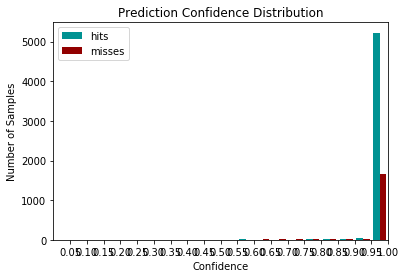

INFO - metrics.py - 13: ROC AUC score: 0.7566399175325424


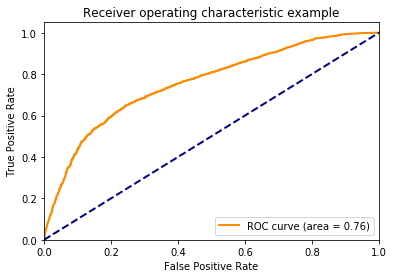

In [13]:
torch.cuda.empty_cache()
!nvidia-smi


# predict on the test data
preds = run_batched_prediction(args, model, test_x, device)

# evaluation
eval_model(args, test_y, preds, ['kept', 'removed'])
